In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
import os
import itertools

In [63]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [64]:
data_orders = pd.read_csv(r"orders.csv")
data_orders['date'] = pd.to_datetime(data_orders['date'])

In [65]:
data_orders['year'] = data_orders.date.dt.year
data_orders['month'] = data_orders.date.dt.month
data_orders['week'] = data_orders.date.dt.isocalendar().week.astype('int32')
data_orders['day_of_week'] = data_orders.date.dt.dayofweek
data_orders['day'] = data_orders.date.dt.day
data_orders['hour'] = data_orders.date.dt.hour

In [66]:
data_partners = pd.read_csv(r"partners_delays.csv")
data_partners['dttm'] = pd.to_datetime(data_partners['dttm'])

In [67]:
data_orders.head()

,delivery_area_id,date,orders_cnt,year,month,week,day_of_week,day,hour
0,0,2021-04-01 10:00:00,9,2021,4,13,3,1,10
1,0,2021-04-01 11:00:00,1,2021,4,13,3,1,11
2,0,2021-04-01 13:00:00,1,2021,4,13,3,1,13
3,0,2021-04-01 14:00:00,1,2021,4,13,3,1,14
4,0,2021-04-01 15:00:00,2,2021,4,13,3,1,15


In [68]:
data_partners.head()

,delivery_area_id,dttm,partners_cnt,delay_rate
0,0,2021-04-01 09:00:00,3.0,0.000000
1,0,2021-04-01 10:00:00,4.0,0.111111
2,0,2021-04-01 11:00:00,4.0,0.000000
3,0,2021-04-01 12:00:00,4.0,0.000000
4,0,2021-04-01 13:00:00,1.0,0.000000


**Часы работы**
- В таблице orders есть пропуски (внутри дней пропущенные некоторые часы), это на самом деле значит, что в эти часы было 0 заказов.
- Нужно восполнить эти пропуски, так как для обучения модели это важно, чтобы не нарушалась переодичность данных. Выясним в какие часы работает каждая зона доставки и уберем в этих интревалах времени пробелы. Дополнять данные по дню до целых суток не буду, так как во время когда  зона доставки не работает будет везде 0 заказов. На переодичность это не повляет.

Время работы зон будем смотреть через таблицу partners_delays так как она более полная и без пропусков

Все зоны работают разное количество часов, в разное времея начинают и заканчивают, но каждая внутри каждой ЗД часы всегда совпадают. Кроме одного случая в 248ой ЗД, она в один день проработала другое время, считаем что она работает 14 часов с 10 00 до 23 00

In [72]:
groups = data_partners.groupby(by=['delivery_area_id','month','day'], dropna=False)

In [73]:
lst=[]
k=-1
for vals, group in groups:
    if k==-1:
        max_date = pd.to_datetime('2021-04-01 09:00:00')
        k=vals[0]
        work_hours = {}
        work_start = {}
        work_end = {}
    elif vals[0] != k:
        lst.append([k, max(work_hours, key=work_hours.get), max(work_start, key=work_start.get), max(work_end, key=work_end.get), max_date])
        k = vals[0]
        max_date = pd.to_datetime('2021-04-01 09:00:00')
        work_hours = {}
        work_start = {}
        work_end = {}
    
    try:
        work_hours[group.shape[0]] += 1
    except:
        work_hours[group.shape[0]] = 1
    
    try:
        work_start[min(group.hour)] += 1
    except:
        work_start[min(group.hour)] = 1
        
    try:
        work_end[max(group.hour)] += 1
    except:
        work_end[max(group.hour)] = 1
    
    if max(group.dttm) > max_date:
        max_date = max(group.dttm)

lst.append([k, max(work_hours, key=work_hours.get), max(work_start, key=work_start.get), max(work_end, key=work_end.get), max_date])
        
work_hours = pd.DataFrame(data = lst, columns = ['delivery_area_id','hours','start','end', 'max_date'])

In [74]:
work_hours.head()

,delivery_area_id,hours,start,end,max_date
0,0,14,9,22,2021-11-30 22:00:00
1,1,14,8,21,2021-11-30 21:00:00
2,2,12,10,21,2021-11-30 21:00:00
3,3,13,9,21,2021-11-30 21:00:00
4,4,13,10,22,2021-11-30 22:00:00


In [75]:
work_hours.max_date.unique()

array(['2021-11-30T22:00:00.000000000', '2021-11-30T21:00:00.000000000',
       '2021-11-30T20:00:00.000000000'], dtype='datetime64[ns]')

In [14]:
work_hours.to_csv(os.getcwd()+'\work_hours_by_areas.csv',index=False)

**Дополняем orders нулями в соотвествии с часами работы зоны доставки**

In [ ]:
groups = data_orders.groupby(by=['delivery_area_id','month','day'], dropna=False)

In [ ]:
lst=[]
for vals, group in tqdm(groups):
    area = vals[0]
    start_work = work_hours[work_hours.delivery_area_id == area].start.item()
    end_work = work_hours[work_hours.delivery_area_id == area].end.item()
    hours = end_work - start_work + 1
    if hours == group.shape[0]:
        lst.append(group)
    else:
        year = group.iloc[0,3]
        month = group.iloc[0,4]
        week = group.iloc[0,5]
        day_of_week = group.iloc[0,6]
        day = group.iloc[0,7]
        for hour in range(start_work, end_work+1):
            if group[group.date.dt.hour == hour].empty:
                group = group.append({'delivery_area_id':area,
                                      'date': pd.to_datetime(f'{year}-{month}-{day} {hour}:00:00'),
                                      'orders_cnt':0,
                                      'year':year,
                                      'month':month,
                                      'week':week,
                                      'day_of_week':day_of_week,
                                      'day':day,
                                      'hour':hour}, ignore_index= True)
        group = group.sort_values(by = 'date')
        lst.append(group)
data_orders = pd.concat(lst, ignore_index=True)

Сохраняем

In [ ]:
data_orders.to_csv(os.getcwd()+'\orders_modified.csv',index=False)

**Добавим partners delays данные по количеству заказов в соотвествии с датой и зоной доставки**

In [ ]:
def orders_count(x):
    try:
        return data_orders[(data_orders.date == x.dttm) & (data_orders.delivery_area_id == x.delivery_area_id)].orders_cnt.item()
    except: 
        return np.nan

In [ ]:
data_partners['orders_cnt'] = data_partners.apply(func = orders_count, axis=1)

In [ ]:
data_partners = data_partners.fillna(0)

In [71]:
data_partners['year'] = data_partners.dttm.dt.year
data_partners['month'] = data_partners.dttm.dt.month
data_partners['week'] = data_partners.dttm.dt.isocalendar().week.astype('int32')
data_partners['day_of_week'] = data_partners.dttm.dt.dayofweek
data_partners['day'] = data_partners.dttm.dt.day
data_partners['hour'] = data_partners.dttm.dt.hour

Сохраняем

In [64]:
data_partners.to_csv(os.getcwd()+'\partners_delays_modified.csv',index=False)

**Дневная сумма заказов**

In [6]:
data_orders = pd.read_csv(r"orders_modified.csv")

In [7]:
data_orders.head()

,delivery_area_id,date,orders_cnt,year,month,week,day_of_week,day,hour
0,0,2021-04-01 09:00:00,0.0,2021,4,13,3,1,9
1,0,2021-04-01 10:00:00,9.0,2021,4,13,3,1,10
2,0,2021-04-01 11:00:00,1.0,2021,4,13,3,1,11
3,0,2021-04-01 12:00:00,0.0,2021,4,13,3,1,12
4,0,2021-04-01 13:00:00,1.0,2021,4,13,3,1,13


In [8]:
groups = data_orders.groupby(by=['delivery_area_id','month','day'], dropna=False)

In [9]:
lst=[]
for vals, group in tqdm(groups):
    area = vals[0]
    month = vals[1]
    week = group.iloc[0,5]
    day = vals[2]
    year = group.iloc[0,3]
    count = sum(group.orders_cnt)
    date = pd.to_datetime(f'{year}-{month}-{day}')
    lst.append([area, date, count, year, month, week, day])
daily_orders = pd.DataFrame(data= lst, columns=['delivery_area_id','date','orders_cnt','year','month', 'week','day'])

  0%|          | 0/99337 [00:00<?, ?it/s]

In [10]:
groups = daily_orders.groupby(by=['month','day'], dropna=False)

In [11]:
lst=[]
for vals, group in tqdm(groups):
    group.loc[:,'orders_cnt_day'] = sum(group.orders_cnt)
    lst.append(group)
daily_orders = pd.concat(lst, ignore_index=True)

  0%|          | 0/244 [00:00<?, ?it/s]

In [12]:
daily_orders.head()

,delivery_area_id,date,orders_cnt,year,month,week,day,orders_cnt_day
0,0,2021-04-01,24.0,2021,4,13,1,1280.0
1,1,2021-04-01,27.0,2021,4,13,1,1280.0
2,2,2021-04-01,21.0,2021,4,13,1,1280.0
3,3,2021-04-01,11.0,2021,4,13,1,1280.0
4,4,2021-04-01,13.0,2021,4,13,1,1280.0


Сохраняем

In [47]:
daily_orders.to_csv(os.getcwd()+'\daily_orders.csv',index=False)

**Создание тестового набора данных** (7 дней после 2021-11-30), для которого нужно:
- Предсказать кол-во заказов по часам
- Подобрать оптимальное кол-во курьеров, чтобы delay_rate был < 0.05
- Составить оптимальное расписание из 4,5,6,7,8 часовых смен

In [76]:
dates = ['2021-12-01','2021-12-02','2021-12-03','2021-12-04','2021-12-05','2021-12-06','2021-12-07']
columns = ['delivery_area_id','date']
lst = []
for date in tqdm(dates):
    for area in data_orders.delivery_area_id.unique():
        start = work_hours[work_hours.delivery_area_id == area].start.item()
        end = work_hours[work_hours.delivery_area_id == area].end.item()
        for hour in range(start, end + 1):
            lst.append([area, pd.to_datetime(f'{date} {hour}:00:00')])
test_data = pd.DataFrame(data=lst, columns =columns)

  0%|          | 0/7 [00:00<?, ?it/s]

In [77]:
test_data = test_data.sort_values(by=['delivery_area_id','date'])

In [78]:
test_data['year'] = test_data.date.dt.year
test_data['month'] = test_data.date.dt.month
test_data['week'] = test_data.date.dt.isocalendar().week.astype('int32')
test_data['day_of_week'] = test_data.date.dt.dayofweek
test_data['day'] = test_data.date.dt.day
test_data['hour'] = test_data.date.dt.hour

In [80]:
test_data.head()

,delivery_area_id,date,year,month,week,day_of_week,day,hour
0,0,2021-12-01 09:00:00,2021,12,48,2,1,9
1,0,2021-12-01 10:00:00,2021,12,48,2,1,10
2,0,2021-12-01 11:00:00,2021,12,48,2,1,11
3,0,2021-12-01 12:00:00,2021,12,48,2,1,12
4,0,2021-12-01 13:00:00,2021,12,48,2,1,13


In [82]:
test_data.to_csv(os.getcwd()+'\test_data.csv', index=False)

In [20]:
daily_orders.head()

,delivery_area_id,date,orders_cnt,year,month,week,day,orders_cnt_day
0,0,2021-04-01,24.0,2021,4,13,1,1280.0
1,1,2021-04-01,27.0,2021,4,13,1,1280.0
2,2,2021-04-01,21.0,2021,4,13,1,1280.0
3,3,2021-04-01,11.0,2021,4,13,1,1280.0
4,4,2021-04-01,13.0,2021,4,13,1,1280.0


In [14]:
daily_orders[daily_orders.delivery_area_id == 2]

In [41]:
cols= ['delivery_area_id', 'zeros', 'dead']
lst = []
for area in tqdm(daily_orders.delivery_area_id.unique()):
    n = daily_orders[daily_orders.delivery_area_id == area].shape[0]
    zeros = daily_orders[(daily_orders.delivery_area_id == area) & (daily_orders.orders_cnt == 0)].shape[0]
    last_7 = daily_orders[daily_orders.delivery_area_id == area].iloc[-7:,:]
    if last_7[last_7.orders_cnt == 0].shape[0] == 7:
        dead = 1
    else:
        dead = 0
    lst.append([area, zeros*100/n , dead])
    
zeros = pd.DataFrame(data = lst, columns = cols)

  0%|          | 0/593 [00:00<?, ?it/s]

In [43]:
zeros[zeros.dead == 1]

,delivery_area_id,zeros,dead
2,2,93.852459,1
64,453,65.163934,1
143,195,21.301775,1
336,190,23.270440,1
337,200,25.786164,1
354,367,35.849057,1
371,181,48.101266,1
372,182,12.025316,1


зона 2, 453, 195, 190, 200, 367, 181, 182

In [59]:
qqq = daily_orders[daily_orders.delivery_area_id == 182]

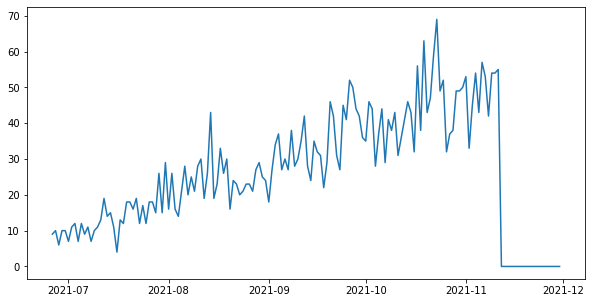

In [60]:
plt.figure(figsize=(10,5))
plt.plot(qqq.date, qqq.orders_cnt)
plt.show()